In [101]:
import pandas as pd
import numpy as np
import gutenbergpy.textget
import re
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from plotnine import *

In [96]:
book_authors = {
    'Charles Dickens': [46, 98, 1400, 730, 766, 1023],
    'Herman Melville': [2701, 11231, 15859, 21816, 34970, 10712],
    'Jane Austen': [1342, 158, 161, 105, 121, 141]
}
book_authors_test = {
    'Charles Dickens': [786, 580, 883],
    'Herman Melville': [2384, 4045, 8118, 2694, 13720, 53861],
    'Jane Austen': [946]
}

In [97]:
book_contents = {}
for book_id in [book_id for id_list in book_authors.values() for book_id in id_list]:
    # Load in the book
    raw_book = gutenbergpy.textget.get_text_by_id(book_id)
    clean_book = gutenbergpy.textget.strip_headers(raw_book)
    # Convert to string
    book = clean_book.decode('UTF-8')
    # Save the book contents
    book_contents[book_id] = book


In [103]:
books_wtoks = {}
books_stoks = {}
for book_id, book in book_contents.items():
    tokenizer = RegexpTokenizer(r'\w+')
    books_wtoks[book_id] = tokenizer.tokenize(book)
    books_stoks[book_id] = sent_tokenize(book)

In [104]:
book_stats = {}
for book_id in book_contents.keys():
    book_stats[book_id] = {}
    book_stok = books_stoks[book_id]
    book_wtok = books_wtoks[book_id]
    (book_stats[book_id])['sent_chars'] = [len(sent) for sent in book_stok]
    (book_stats[book_id])['sent_words'] = [len(word_tokenize(sent)) for sent in book_stok]
    (book_stats[book_id])['word_chars'] = [len(word) for word in book_wtok]

In [105]:
# Convert to data frames
stat_dfs = {}
stat_names = book_stats[list(book_stats.keys())[0]]
for stat_name in stat_names:
    stat_data = {book_id:book_stat[stat_name] for book_id, book_stat in book_stats.items()}
    stat_data_df = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in stat_data.items()}, orient='columns')
    stat_data_df_long = pd.melt(stat_data_df).dropna(how='any')
    stat_data_df_long.columns = ['book_id', stat_name]
    book_authors_df = pd.melt(pd.DataFrame.from_dict({k:pd.Series(v) for k, v in book_authors.items()}))
    book_authors_df.columns = ['author_name', 'book_id']
    stat_df_final = stat_data_df_long.merge(book_authors_df, on='book_id', how='left')
    stat_df_final = stat_df_final.sort_values('author_name')
    stat_dfs[stat_name] = stat_df_final

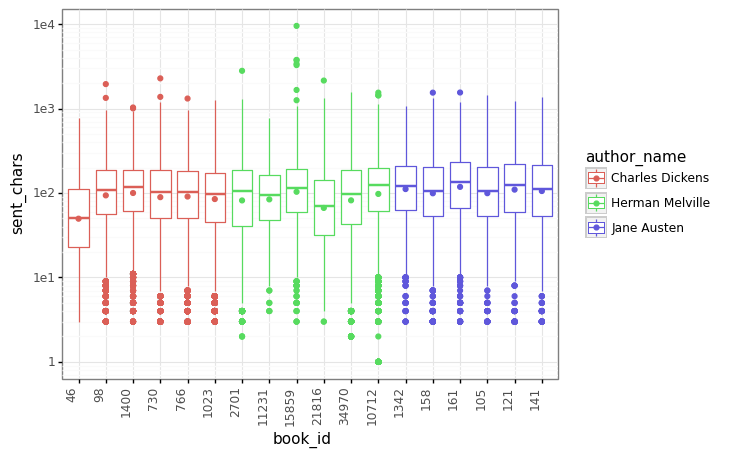

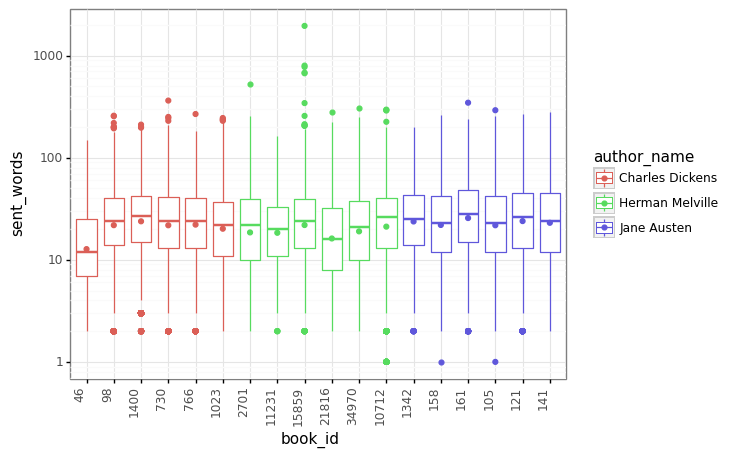

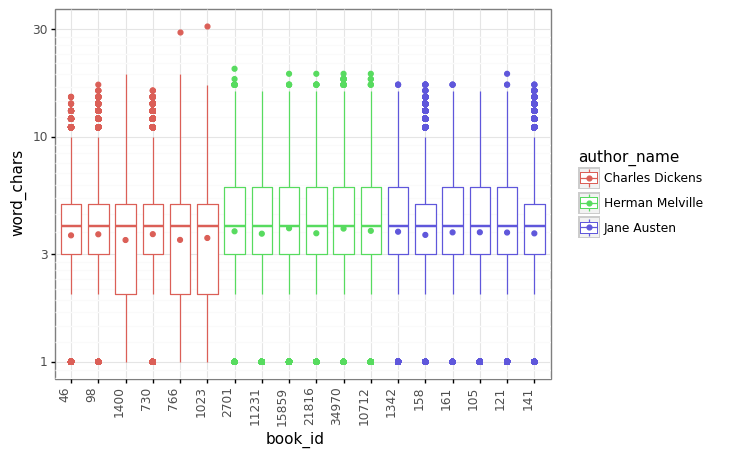

In [106]:
for plot_var in stat_dfs.keys():
    graph_df = stat_dfs[plot_var]
    graph_df['book_id'] = pd.Categorical(graph_df['book_id'])
    book_order = book_authors['Charles Dickens'] + book_authors['Herman Melville'] + book_authors['Jane Austen']
    plot = (
        ggplot(stat_dfs[plot_var], aes(x='book_id', y=plot_var, color='author_name'))
        + geom_boxplot()
        + scale_y_log10()
        + stat_summary(fun_y=np.mean, geom='point')
        + scale_x_discrete(limits=book_order)
        + theme_bw()
        + theme(axis_text_x=element_text(rotation=90, hjust=1))
    )
    plot.draw(show=True)


In [151]:
# Find ngrams in each book
book_grams = {}
gram_length = 2
for author, books in book_authors.items():
    for book_id in books:
        #book = book_contents[book_id]
        top_grams = pd.Series(sorted(ngrams(books_wtoks[book_id], gram_length))).value_counts()
        book_grams[book_id] = top_grams


In [152]:
# Find ngrams that appear in all of the books by the same author by joining the data frames together with inner joins
author_ngs = {}
for author, books in book_authors.items():
    ng_df = pd.DataFrame(book_grams[books[0]]).reset_index()
    ng_df.columns = ['ng', f'count_{books[0]}']
    for book_id in books[1:]:
        new_ng_df = pd.DataFrame(book_grams[book_id]).reset_index()
        new_ng_df.columns = ['ng', f'count_{book_id}']
        ng_df = ng_df.merge(new_ng_df, on='ng')
    author_ngs[author] = ng_df

In [155]:
# Show which ngrams are unique to an author
# Create a combined data frames of ngrams for each author, with a mean number of times they appear in the author's work per book
get_mean_words = lambda x: x.drop('ng', axis=1).median(axis=1)
ja_ng = author_ngs['Jane Austen'].assign(mean_ja=get_mean_words)
hm_ng = author_ngs['Herman Melville'].assign(mean_hm=get_mean_words)
cd_ng = author_ngs['Charles Dickens'].assign(mean_cd=get_mean_words)
author_ngs_combined = (
    ja_ng
    .merge(hm_ng, on='ng', how='outer')
    .merge(cd_ng, on='ng', how='outer')
)
# Find ngrams that only appear in one author's work
uniq_ngs = (
    author_ngs_combined
    .filter(['ng','mean_cd','mean_ja','mean_hm'])
    .assign(books_with_ng=lambda x: (x.mean_cd > 0).astype(int) + (x.mean_ja > 0).astype(int) + (x.mean_hm > 0).astype(int))
    .query('books_with_ng == 1')
)
# Show unique ngrams for each author
for author in ['cd','ja','hm']:
    ngs = uniq_ngs.query(f'mean_{author}> 1').sort_values(f'mean_{author}', ascending=False).head(10)
    print(f'Author "{author}" most common n-grams: ', ngs.ng.tolist())

Author "cd" most common n-grams:  [('I', 'don'), ('the', 'fire'), ('it', 's'), ('It', 's'), ('t', 'know'), ('Don', 't'), ('I', 'm'), ('didn', 't'), ('wouldn', 't'), ('couldn', 't')]
Author "ja" most common n-grams:  [('she', 'could'), ('her', 'own'), ('her', 'to'), ('She', 'had'), ('and', 'Mrs'), ('which', 'she'), ('from', 'her'), ('what', 'she'), ('at', 'her'), ('as', 'much')]
Author "hm" most common n-grams:  [('at', 'times'), ('still', 'more'), ('the', 'stranger'), ('these', 'things'), ('owing', 'to'), ('in', 'hand'), ('would', 'seem'), ('the', 'white'), ('as', 'yet'), ('sir', 'I')]
